(tune-equinox)=
# Tune Neural ODE Models Using Jax and Equinox
## What is a neural differential equation?
First, recall that a differential equation is an equation which relates a function to its derivative 

$$\frac{d\vec{y}}{dt} = f(t, \vec{y}(t))$$

A solution to this equation takes the form

$$\vec{y}(t) = \vec{y}(0) + \int_0^t{f(s, \vec{y}(s))ds}$$

where $\vec{y}(0)$ is the initial condition for the solution.

If we don't know what function `f` is, we can approximate it using a trainable function such as a deep neural network with learnable weights. This idea is the basis of neural differential equations and can be generalized to most forms of differential equations (stochastic, controlled, partial, delay, etc.). Further, we can use this dynamical framework to improve performance on tasks not that are not inherently dynamical, like [image recoginition](https://arxiv.org/pdf/2312.01657). Efficient handling of backpropagation via adjoints is an important topic discussed more [here](https://docs.kidger.site/diffrax/api/adjoints/), and notably [innovated by Chen et al in 2018](https://arxiv.org/abs/1806.07366), but that is outside of the scope of this tutorial.

In this example, we will train the neural network for signal forecasting, but many other training options like classification or sequence-to-sequence generation are possible.

## Why Jax?
[Jax](https://jax.dev) is an accelerator-focused framework for array computations and program transformations, including automatic differentiation, compilation, and parallelization. Like PyTorch, Jax uses a similar API to NumPy, which makes transitioning feel smoother for developers familiar with the NumPy or PyTorch frameworks. Jax makes it easy to Just-in-Time (JIT) compile Python code, run the same code on CPUs, GPUs, and TPUs, and parallelize workflows. These properties make Jax an ideal candidate for accelerating deep learning tasks, and Ray can allow us one level on top of Jax to manage accelerator scheduling and to apply efficient hyperparameter tuning algorithms.

In this example, we use [Equinox](https://docs.kidger.site/equinox) to define our neural network model, [Diffrax](https://docs.kidger.site/diffrax) for differential equation solvers, and [optax](https://github.com/google/optax) to optimize the parameters of our neural networks. To avoid system deadlocks on the CPU, make sure to run the network training on the GPU by installing the `cuda12` extras for Jax.

:::{note}
To run this example, you will need to install the following:

```bash
$ pip install ray jax[cuda12] diffrax equinox optax
```
:::

```{contents}
:backlinks: none
:local: true
```

## Package imports

Let's start by importing the packages we'll need for this example

In [1]:
import os
# Prevent preeallocating entire GPU memory, locking us out of the device
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import tempfile
import copy
import json

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax
import optax
from orbax.checkpoint import PyTreeCheckpointer

import matplotlib.pyplot as plt

from ray import tune
from ray.tune import Checkpoint
from ray.tune.schedulers import ASHAScheduler

## Create the model

We'll be building on the example from the [Diffrax documentation](https://docs.kidger.site/diffrax/examples/neural_ode) on Neural ODEs by adding hyperparameter tuning. Our first step toward building a neural ODE model in equinox is to build the core neural network driving the dynamics, which we will call `Func`. Referring back to the description of neural differential equations, this model will serve as the trainable function, $f_\theta$, where $\theta$ are the network parameters we will optimize. There are several parameters we need to provide here:
- `ode_size`: The number of dimensions/features our model will input/output
- `width_size`: The number of neurons in each layer of the network
- `depth`: The number of layers in the network

We will also provide a pseudorandom `key` keyword argument (given as a `jax.random.PRNGKey`), which Jax will use for reproducible randomization. 

In [2]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    scale: float

    def __init__(self, ode_size, width_size, depth, *, key, scale=1.0, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.mlp = eqx.nn.MLP(
            in_size=ode_size,
            out_size=ode_size,
            width_size=width_size,
            depth=depth,
            activation=jax.nn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.scale * self.mlp(y)

Next, we'll define a `NeuralODE` class which will hold handle the logic for using the `Func` network's parameters in an ordinary differential equation solver. For this example, we'll use the `diffrax.Tsit5()` solver when training the model, but we could use simpler solvers like `diffrax.Euler()` for faster training or more complex solvers tailored for different scenarios. For a complete list of solvers and a guide for how to choose the correct solver for your situation, see the [Diffrax documentation](https://docs.kidger.site/diffrax/usage/how-to-choose-a-solver/). 

In [3]:
class NeuralODE(eqx.Module):
    func: eqx.Module

    def __init__(self, ode_size, width_size, depth, *, key, scale=1.0):
        self.func = Func(ode_size, width_size, depth, key=key, scale=scale)

    def __call__(self, ts, ys):
        y0 = ys[0, :]
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-5),
            saveat=diffrax.SaveAt(ts=ts),
            max_steps=8192,
        )
        return solution.ys

## Create training data

Now, let's make some example data. These will just be simple oscillatory signals that look like deformed sines and cosines.

In [4]:
def _get_data(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1)

    def f(t, y, args):
        x = y / (1 + y)
        return jnp.stack([x[1], -x[0]], axis=-1)

    solver = diffrax.Tsit5()
    dt0 = 0.1
    saveat = diffrax.SaveAt(ts=ts)
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
    )
    ys = sol.ys
    return ys


def get_data(dataset_size, *, key):
    ts = jnp.linspace(0, 10, 100)
    key = jr.split(key, dataset_size)
    ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
    return ts, ys

Create a generator function to batch our data

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while start < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Set global parameters
Here, we set some global parameters that will be shared by all training sessions, including creating the data and the search space we'll use for `ray.tune`. We'll also only use the first half of our signals for training and the second half of the signals to evaluate how well our models are fit and extrapolate.

In [6]:
steps = 1000
checkpoint_every = 500
seed = 5678
dataset_size = 256
key = jr.PRNGKey(seed)
data_key, model_key, loader_key = jr.split(key, 3)

ts, ys = get_data(dataset_size, key=data_key)

train_size = 0.6
train_ts, test_ts = ts[:int(jnp.ceil(train_size * len(ts)))], ts[int(jnp.ceil(train_size * len(ts))):]
train_ys, test_ys = ys[:, :int(jnp.ceil(train_size * len(ts)))], ys[:, int(jnp.ceil(train_size * len(ts))):]
_, length_size, data_size = train_ys.shape

config = {
    "batch_size": tune.choice([32, 128, 512]),
    "lr": tune.loguniform(1e-7, 1e-2),
    "width_size": tune.choice([32, 128, 512]),
    "depth": tune.choice([1, 3, 5]),
}

## Define the training loop
Now, we'll define a function `train_fn` that takes a configuration dictionary, creates the model, and trains it. We also have some logic to handle checkpointing and resuming from checkpoints here.

In [7]:
def train_fn(config):
    batch_size = config["batch_size"]
    width_size = config["width_size"]
    depth = config["depth"]
    lr = config["lr"]

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi)
        return jnp.mean((yi - y_pred) ** 2)

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    optim = optax.adabelief(lr)

    checkpoint = tune.get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            opt_state_loc = os.path.join(checkpoint_dir, "opt_state.eqx")
            model_loc = os.path.join(checkpoint_dir, "model.eqx")

            base_model = NeuralODE(
                ode_size=data_size,
                width_size=width_size,
                depth=depth,
                key=model_key
            )

            model = eqx.tree_deserialise_leaves(model_loc, copy.deepcopy(base_model))
            opt_state = optim.init(eqx.filter(model, eqx.is_array))
            opt_state = eqx.tree_deserialise_leaves(opt_state_loc, opt_state)

    else:
        opt_state = optim.init(eqx.filter(model, eqx.is_array))

    for step, (yi,) in zip(
        range(steps), dataloader((train_ys,), batch_size, key=loader_key)
    ):
        loss, model, opt_state = make_step(train_ts, yi, model, opt_state)

        test_model_ys = jax.vmap(model, in_axes=(None, 0))(test_ts, test_ys)
        test_loss = jnp.mean((test_model_ys - test_ys)**2)
        checkpoint_data = {
            "train_loss": float(loss),
            "test_loss": float(test_loss),
            "step": int(step),
        }
        if (step % checkpoint_every) == 0:
            with tempfile.TemporaryDirectory() as temp_dir:
                ckpt_loc = os.path.join(temp_dir, "checkpoint")
                PyTreeCheckpointer().save(ckpt_loc, checkpoint_data)
                opt_state_loc = os.path.join(ckpt_loc, "opt_state.eqx")
                model_loc = os.path.join(ckpt_loc, "model.eqx")

                print(f"Creating checkpoint at {ckpt_loc}")

                eqx.tree_serialise_leaves(model_loc, model)
                eqx.tree_serialise_leaves(opt_state_loc, opt_state)

                tune.report(
                    checkpoint_data,
                    checkpoint=Checkpoint.from_directory(ckpt_loc)
                )
        else:
            tune.report(
                checkpoint_data
            )

    return ts, ys, model

## Train the model
The `main` function will run our tuning session.

In [8]:

def main(gpus_per_trial=0.2, SMOKE_TEST=True):
    num_samples = 5 if SMOKE_TEST else 30
    scheduler = ASHAScheduler(max_t=steps, grace_period=200, reduction_factor=2)
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_fn),
            resources={"cpu": 1, "gpu": gpus_per_trial}
        ),
        run_config = tune.RunConfig(
            name="node_asha",
            stop={"training_iteration": steps},
        ),
        tune_config=tune.TuneConfig(
            scheduler=scheduler,
            metric="test_loss",
            mode="min",
            num_samples=num_samples,
            reuse_actors=True,
        ),
        param_space=config,
    )
    results = tuner.fit()
    return results


In [9]:
results = main()

(train_fn pid=3533003) Creating checkpoint at /tmp/tmp_12l0j7m/checkpoint


(train_fn pid=3533003) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/michael/ray_results/node_asha/train_fn_ead0e_00001_1_batch_size=512,depth=1,lr=0.0000,width_size=512_2025-02-28_22-54-47/checkpoint_000000)


(train_fn pid=3533005) Creating checkpoint at /tmp/tmpxa76wl7s/checkpoint [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)


(train_fn pid=3533005) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/michael/ray_results/node_asha/train_fn_ead0e_00000_0_batch_size=32,depth=3,lr=0.0009,width_size=128_2025-02-28_22-54-46/checkpoint_000001) [repeated 5x across cluster]


(train_fn pid=3533006) Creating checkpoint at /tmp/tmpds71k532/checkpoint


(train_fn pid=3533006) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/michael/ray_results/node_asha/train_fn_ead0e_00002_2_batch_size=32,depth=5,lr=0.0024,width_size=32_2025-02-28_22-54-47/checkpoint_000001)
2025-02-28 22:59:00,193	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/michael/ray_results/node_asha' in 0.0037s.
2025-02-28 22:59:00,196	INFO tune.py:1041 -- Total run time: 253.29 seconds (253.24 seconds for the tuning loop).


## Evaluate the training results
Now that the tuning session has completed, let's load the best weights and show the extrapolation capabilities of our neural ODE model!

In [10]:
best_result = results.get_best_result().get_best_checkpoint(metric="test_loss", mode="min").path
base_best_result = best_result.split("/")[:-1]

base = ""
for path_elem in base_best_result:
    base += path_elem + "/"

config_loc = base + "params.json"
with open(config_loc, "rb") as f:
    config = json.load(f)

model = NeuralODE(
    ode_size=data_size,
    depth=config["depth"],
    width_size=config["width_size"],
    key=jax.random.PRNGKey(42)
)

model = eqx.tree_deserialise_leaves(os.path.join(best_result, "model.eqx"), model)

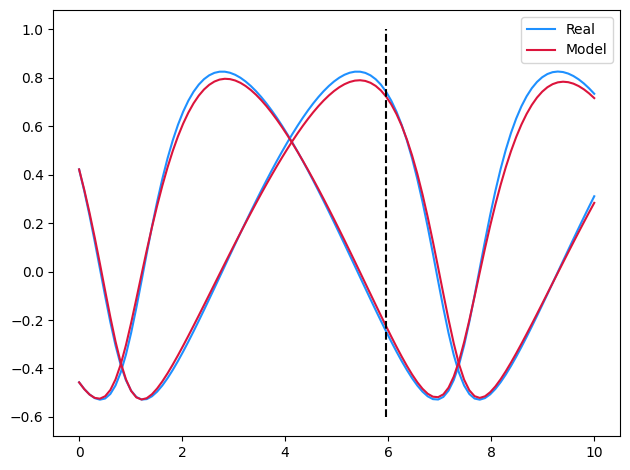

In [11]:
plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, ys[0, :, 1], c="dodgerblue")
model_y = model(ts, ys[0, :, :])
plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.vlines(x=[train_ts[-1]], ymin=-0.6, ymax=1, linestyles="--", color="k", label="Training cutoff")
plt.legend()
plt.tight_layout()
plt.show()